In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib
from gplearn.genetic import SymbolicRegressor
from sklearn.tree import DecisionTreeRegressor
from sympy import *
from gplearn.functions import make_function
import warnings
warnings.filterwarnings("ignore")
# https://gplearn.readthedocs.io/en/stable/examples.html#symbolic-regressor

auth = pd.read_excel('auth.xlsx', skiprows=[1, 2], index_col = 0, engine='openpyxl')
sigma = pd.read_excel('sigma0.xlsx', index_col = 0, engine='openpyxl')
pm = pd.read_excel('PM.xlsx', index_col = 0, engine='openpyxl')

In [20]:
def pow_3(x1):
    f = x1**3
    return f

def pow_4(x1):
    f = x1**4
    return f

def exp_(x1):
    f = np.exp(x1)
    return f

def internaltanh(x):
    return np.tanh(x)

def tan(x):
    return np.tan(x)

pow_3 = make_function(function=pow_3, name='pow3', arity=1)
pow_4 = make_function(function=pow_4, name='pow4', arity=1)
exp_ = make_function(function=exp_, name='exp_', arity=1)
dtanh = make_function(function=internaltanh, name='dtanh',arity=1)
tan = make_function(function=tan, name='tan',arity=1)

def gen_eq(df, data, goal, function_set, generations = 30):
    try:
        X = data
        y = df[goal]

        y_true = y
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.30, random_state=42)

        '''
        https://gplearn.readthedocs.io/en/stable/reference.html#user-defined-functions

        ‘mean absolute error’.
        ‘mse’ for mean squared error.
        ‘rmse’ for root mean squared error.
        ‘pearson’, for Pearson’s product-moment correlation coefficient.
        ‘spearman’ for Spearman’s rank-order correlation coefficient.
        '''


        est_gp = SymbolicRegressor(population_size=5000, function_set=function_set,
                                   generations=generations, stopping_criteria=0.01,
                                   p_crossover=0.7, p_subtree_mutation=0.1,
                                   p_hoist_mutation=0.05, p_point_mutation=0.1,
                                   max_samples=0.9, verbose=1, metric = 'mse',
                                   parsimony_coefficient=0.01,
                                  feature_names=X_train.columns)

        converter = {
            'add': lambda x, y : x + y,
            'sub': lambda x, y : x - y,
            'mul': lambda x, y : x*y,
            'div': lambda x, y : x/y,
            'sqrt': lambda x : x**0.5,
            'log': lambda x : log(x),
            'abs': lambda x : abs(x),
            'neg': lambda x : -x,
            'inv': lambda x : 1/x,
            'max': lambda x, y : max(x, y),
            'min': lambda x, y : min(x, y),
            'sin': lambda x : sin(x),
            'cos': lambda x : cos(x),
            'pow': lambda x, y : x**y,
            'pow3': lambda x   : x**3,
            'pow4': lambda x   : x**4,
            'exp_': lambda x   : exp(x),
        #     'dtanh': lambda x   : np.tanh(x),
            'tan': lambda x   : np.tan(x)
        }

        est_gp.fit(X_train, y_train)
        next_e = sympify(str(est_gp._program), locals=converter)
        print('Equation: {} & Score: {:.2%}'.format(next_e, est_gp.score(X_test,y_test)))
        # print(next_e)

        est_tree = DecisionTreeRegressor(max_depth=5)
        est_tree.fit(X_train, y_train)
        est_rf = RandomForestRegressor(n_estimators=100,max_depth=5)
        est_rf.fit(X_train, y_train)
        y_gp = est_gp.predict(X_test)
        score_gp = est_gp.score(X_test, y_test)
        y_tree = est_tree.predict(X_test)
        score_tree = est_tree.score(X_test, y_test)
        y_rf = est_rf.predict(X_test)
        score_rf = est_rf.score(X_test, y_test)

        fig = plt.figure(figsize=(12, 10))
        for i, (y, score, title) in enumerate([(y_gp, score_gp, "SymbolicRegressor"),
                                               (y_tree, score_tree, "DecisionTreeRegressor"),
                                               (y_rf, score_rf, "RandomForestRegressor")]):
            ax = fig.add_subplot(2, 2, i+1)
            test = ax.scatter(y, y_test, color='red', alpha=0.5)
            plt.title('{}. Score: {:.2%}'.format(title, score))
        plt.show()
    except:
        print('All NaNs')
        pass

In [2]:
dfs = pd.DataFrame(list(auth.columns), columns = ['auth'])
dfs['pm'] = pd.DataFrame(list(pm.columns))
dfs['sigma'] = pd.DataFrame(list(sigma.columns))
dfs

,auth,pm,sigma
0,Short Date,Station,VV
1,Unnamed: 2,Month,angle
2,Julian,Days,VV_db
3,Count,P,VV_db2
4,T,Rs,VV_var_db
5,Tmax,Tmax,VV_var_db2
6,Tmin,Tmin,SM
7,U,T,ΔVV_db
8,es,RH,P6d
9,es (Tmin),u,NDVI


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.86     1.95258e+131        8            457.4          512.771     35.00s
   1     8.23      4.04371e+47        6          377.376          351.806     25.66s
   2     9.33      5.48083e+83       24          362.429          423.659     15.20s
   3     7.95     1.88992e+137       11          349.539          496.078      7.96s
   4    10.26     1.02127e+110       14           343.07          260.579      0.00s
Equation: -T**0.5*sin(u) + 0.92*(Rs*T**1.5)**0.5 & Score: 91.75%


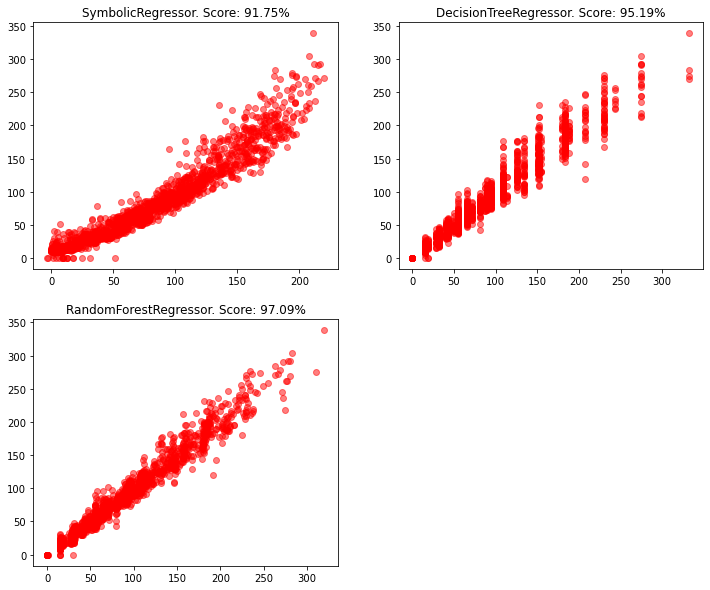

In [70]:
function_set = ['add', 'sub', 'mul', 'div', 'cos', 'sin', 'neg', 'inv', 'sqrt', pow_3]

# 1) =================================================================
# df = auth.dropna() #auth, pm or sigma
# df.reset_index(drop=True, inplace=True)

# df3 = df[['Julian', 'T', 'Tmax', 'Tmin', 'U']]
# df3.reset_index(drop=True, inplace=True)
# data = df3
# goal = 'Ετο'

# 2) =================================================================
df = pm.dropna() #auth, pm or sigma
df.reset_index(drop=True, inplace=True)

df3 = df[['T', 'Rs', 'P', 'u', 'Tmax']]
df3.reset_index(drop=True, inplace=True)
data = df3
goal = 'Etos'

gen_eq(df, data, goal, function_set, generations = 5)

# 3) =================================================================
# df = sigma.dropna() #auth, pm or sigma
# df.reset_index(drop=True, inplace=True)

# df3 = df[['VV_db', 'VV_db2', 'VV_var_db', 'VV_var_db2', 'NDVI']]
# df3.reset_index(drop=True, inplace=True)
# data = df3
# goal = 'SM'

# gen_eq(df, data, goal, function_set, generations = 2)

In [ ]:
# (-Rs*T**1.5)**0.5 - (P + 0.727)**0.5 92.07%
# -T**0.5 + (-Rs*T**1.5)**0.5 & Score: 91.64%
# -T**0.5*sin(u) + 0.92*(Rs*T**1.5)**0.5 & Score: 91.75%

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib
from gplearn.genetic import SymbolicRegressor
from sklearn.tree import DecisionTreeRegressor
from sympy import *
from gplearn.functions import make_function
import warnings
warnings.filterwarnings("ignore")
# https://gplearn.readthedocs.io/en/stable/examples.html#symbolic-regressor

equations = []

for i in range(50):
    try:
        df = pd.read_excel('auth.xlsx', skiprows=[1, 2], index_col = 0, engine='openpyxl')
        df['SoilTemp'] = df['SoilTemp'].fillna(0)
        df3 = df[['Julian', 'T', 'Tmax', 'Tmin', 'U', 'Delta', 'P ', 'RS', 'RH', 'RH_max', 'RH_min', 'SoilTemp', 'Rn', 'Ra', 'dt', 'es-ea', 'N']]
        df3.reset_index(drop=True, inplace=True)
        data = df3.sample(4, axis=1)

        X = data
        y = df['Ετο']

        y_true = y
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.30, random_state=42)

        def pow_3(x1):
            f = x1**3
            return f

        def pow_4(x1):
            f = x1**4
            return f

        def exp_(x1):
            f = np.exp(x1)
            return f

        def tan(x):
            return np.tan(x)

        pow_3 = make_function(function=pow_3, name='pow3', arity=1)
        pow_4 = make_function(function=pow_4, name='pow4', arity=1)
        exp_ = make_function(function=exp_, name='exp_', arity=1)
        tan = make_function(function=tan, name='tan',arity=1)

        '''
        https://gplearn.readthedocs.io/en/stable/reference.html#user-defined-functions

        ‘mean absolute error’.
        ‘mse’ for mean squared error.
        ‘rmse’ for root mean squared error.
        ‘pearson’, for Pearson’s product-moment correlation coefficient.
        ‘spearman’ for Spearman’s rank-order correlation coefficient.
        '''

        function_set = ['add', 'sub', 'mul', 'div', 'cos', 'sin', 'neg', 'inv', pow_3]
        est_gp = SymbolicRegressor(population_size=5000, function_set=function_set,
                                   generations=20, stopping_criteria=0.01,
                                   p_crossover=0.7, p_subtree_mutation=0.1,
                                   p_hoist_mutation=0.05, p_point_mutation=0.1,
                                   max_samples=0.9, verbose=1, metric = 'mse',
                                   parsimony_coefficient=0.01,
                                  feature_names=X_train.columns)

        converter = {
            'add': lambda x, y : x + y,
            'sub': lambda x, y : x - y,
            'mul': lambda x, y : x*y,
            'div': lambda x, y : x/y,
    #         'sqrt': lambda x : x ** 0.5,
            'log': lambda x : log(x),
            'abs': lambda x : abs(x),
            'neg': lambda x : -x,
            'inv': lambda x : 1/x,
            'max': lambda x, y : max(x, y),
            'min': lambda x, y : min(x, y),
            'sin': lambda x : sin(x),
            'cos': lambda x : cos(x),
            'pow': lambda x, y : x**y,
            'pow3': lambda x   : x**3,
            'pow4': lambda x   : x**4,
            'exp_': lambda x   : exp(x),
            'tan': lambda x   : np.tan(x)
        }

        est_gp.fit(X_train, y_train)
        next_e = sympify(str(est_gp._program), locals=converter)
        print('Equation: {} & Score: {:.2%}'.format(next_e, est_gp.score(X_test,y_test)))
        equations.append([list(data.columns), est_gp.score(X_test, y_test), next_e])
    except:
        print('All NaNs')
        pass

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.77     7.23029e+236        7          1.49696          1.28148      2.68m
   1     7.87     4.36606e+102        9          1.44058          1.59014      2.70m
   2     7.62      1.41864e+37        9          1.41487          1.82137      4.41m
   3     6.46      2.58242e+99       17          1.36348          1.58809      3.13m
   4     6.25     1.51526e+251       17          1.36781          1.54912      2.16m
   5     6.86      1.23422e+34       15          1.35374          1.65871      1.91m
   6     5.70      6.31757e+53       18          1.37013          1.45472      1.77m
   7     4.93      4.87449e+71        5          1.40848          1.92692      1.71m
   8     4.89      9.09052e+47        5          1.40806          1.93073  

   0    10.94     1.91389e+260       11         0.959319         0.932764      2.37m
   1     8.06      1.05704e+74       10          0.52636         0.431668      2.03m
   2     7.76      1.00439e+91       10         0.424838         0.689072      1.80m
   3     7.95      4.52219e+74        9         0.422011         0.611972      1.63m
   4    10.05      1.83045e+26       13         0.417155         0.619286      1.72m
   5     9.76      1.84701e+26        8         0.402184         0.795874      1.60m
   6     8.80      4.61978e+22        9         0.399899         0.810837      1.44m
   7     8.33      3.95209e+30        8         0.396054         0.850996      1.35m
   8     7.96      2.71783e+35       11         0.392491         0.578738      1.14m
   9     7.57       8.3978e+30       11         0.387152         0.626753     59.59s
  10     6.88      8.94538e+30        8         0.388768         0.874835     51.82s
  11     5.90      4.62277e+47        6          0.40293         

   4    14.89      1.27961e+47       12         0.627902         0.583486      2.00m
   5    13.51      2.11891e+32       11         0.564803         0.584012      1.76m
   6    10.16      9.33469e+29       18         0.545523         0.726755      1.41m
   7     9.52      2.70542e+32       20         0.534827         0.726626      1.25m
   8    11.26      1.54308e+56        8         0.530994         0.887986      1.33m
   9    11.06     8.63273e+132       13         0.529945         0.879748      1.28m
  10     9.25     1.14708e+264        8         0.528675         0.908834      1.02m
  11     8.01      4.66046e+88       16         0.492489         0.512851     52.52s
  12     7.87      3.31503e+95        9          0.53206         0.830472     46.48s
  13     7.86      1.91839e+81        8          0.53662         0.837387     39.29s
  14     7.64      2.29081e+54        8         0.532011         0.878836     32.27s
  15     7.68       2.5261e+89        8         0.533025         

   4    13.03              nan       15              nan              nan      4.40m
   5    15.09              nan       10              nan              nan      4.25m
   6    17.06              nan       16              nan              nan      4.23m
   7    19.15              nan       27              nan              nan      4.23m
   8    21.41              nan        9              nan              nan      4.31m
   9    24.14              nan       89              nan              nan      4.16m
  10    26.62              nan       39              nan              nan      4.11m
  11    28.88              nan       49              nan              nan      3.89m
  12    31.53              nan       20              nan              nan      3.56m
  13    34.68              nan       39              nan              nan      3.29m
  14    37.33              nan       17              nan              nan      3.09m
  15    40.69              nan       39              nan         

   7     6.15      1.76958e+64        3         0.400918         0.872155      1.31m
   8     6.12      7.96408e+31        9         0.406137         0.880338      1.29m
   9     3.76      7.95946e+31        3         0.400628         0.874763      1.16m
  10     3.16      1.10468e+31        3         0.392861         0.944618     58.62s
  11     3.18      2.34108e+24        3          0.40067         0.874384     49.06s
  12     3.18      1.07102e+33        3         0.403643         0.847643     41.60s
  13     3.17      4.20686e+27        3         0.396821         0.908999     35.92s
  14     3.12      2.7375e+108        3         0.400008         0.880336     30.76s
  15     3.16      1.84264e+32        3         0.406505         0.821906     23.58s
  16     3.14      5.92817e+23        3         0.403089         0.852631     17.76s
  17     3.17      1.22174e+43        3         0.405741         0.828776     12.73s
  18     3.15       6.4689e+31        3         0.397586         

  10    26.14              nan       20              nan              nan      3.76m
  11    28.94              nan       78              nan              nan      4.01m
  12    31.97              nan       36              nan              nan      3.62m
  13    35.07              nan       27              nan              nan      3.14m
  14    38.93              nan       34              nan              nan      2.85m
  15    42.80              nan       82              nan              nan      2.40m
  16    46.44              nan       23              nan              nan      1.95m
  17    50.45              nan       22              nan              nan      1.38m
  18    54.76              nan       51              nan              nan     46.10s
  19    57.87              nan       15              nan              nan      0.00s
Equation: RH**81/cos(sin(RH**27 - RH**3))**27 & Score: -inf%
    |   Population Average    |             Best Individual              |
---- ---------

  13    34.18              nan       40              nan              nan      3.34m
  14    37.07              nan       58              nan              nan      2.95m
  15    40.15              nan       79              nan              nan      2.44m
  16    43.87              nan       37              nan              nan      1.93m
  17    46.72              nan       63              nan              nan      1.36m
  18    50.41              nan       44              nan              nan     43.30s
  19    53.73              nan       60              nan              nan      0.00s
All NaNs
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.79      2.5272e+208        5           1.4936          1.83257      2.74m
   1     8.30      2.18426e+45        4         0.676443         0

  16    73.55              nan      125              nan              nan      1.93m
  17    77.72              nan      220              nan              nan      1.48m
  18    81.74              nan      111              nan              nan     46.27s
  19    86.69              nan       74              nan              nan      0.00s
All NaNs
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.00              nan        9              nan              nan      2.54m
   1     7.50              nan       10              nan              nan      2.38m
   2     7.74              nan       10              nan              nan      2.09m
   3     4.97              nan       11              nan              nan      1.98m
   4     4.14              nan       10              nan          

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.94     2.62247e+166        4          1.19297         0.924421      2.24m
   1     8.18      5.48841e+74        4          1.14891          1.32068      2.16m
   2     8.62       5.1163e+90        4          1.13526          1.44343      2.01m
   3     8.16      5.64901e+46        4          1.11767          1.60157      2.01m
   4     5.29      4.81768e+95        4          1.10659          1.70123      1.62m
   5     4.16      1.3864e+299        4          1.11191          1.65338      1.65m
   6     4.12     9.74149e+155        4          1.10529          1.71292      1.37m
   7     4.09      2.07445e+67        4          1.11539          1.62207      1.28m
   8     4.09      1.18371e+42        4          1.09395          1.81492  

   0    11.13              nan        8              nan              nan      2.35m
   1     8.22              nan        8              nan              nan      2.40m
   2     8.34              nan        8              nan              nan      2.13m
   3     7.60              nan       10              nan              nan      2.14m
   4     8.34              nan       11              nan              nan      3.24m
   5    11.95              nan       12              nan              nan      3.92m
   6    13.51              nan       27              nan              nan      4.39m
   7    15.06              nan       29              nan              nan      3.24m
   8    16.82              nan       13              nan              nan      3.73m
   9    18.50              nan       18              nan              nan      3.56m
  10    20.09              nan       11              nan              nan      3.06m
  11    21.83              nan       31              nan         

   4    14.22              nan       27              nan              nan      3.75m
   5    16.69              nan       36              nan              nan      3.95m
   6    18.72              nan       10              nan              nan      4.62m
   7    20.86              nan       27              nan              nan      4.30m
   8    22.95              nan       60              nan              nan      3.97m
   9    25.40              nan       31              nan              nan      4.14m
  10    28.08              nan        6              nan              nan      3.78m
  11    30.62              nan       18              nan              nan      3.63m
  12    33.13              nan        9              nan              nan      3.32m
  13    35.78              nan       25              nan              nan      3.15m
  14    38.84              nan       29              nan              nan      2.66m
  15    41.57              nan       36              nan         

   8    20.58              nan       18              nan              nan      3.42m
   9    22.91              nan       25              nan              nan      3.49m
  10    25.66              nan       48              nan              nan      3.41m
  11    27.88              nan       24              nan              nan      3.09m
  12    29.74              nan       66              nan              nan      2.96m
  13    31.60              nan       16              nan              nan      2.56m
  14    33.91              nan       42              nan              nan      2.23m
  15    36.65              nan       68              nan              nan      1.99m
  16    38.69              nan       29              nan              nan      1.58m
  17    41.14              nan       64              nan              nan      1.10m
  18    44.17              nan       23              nan              nan     33.94s
  19    46.57              nan       89              nan         

  13     5.78      2.79627e+40        8         0.587801         0.740337     32.73s
  14     5.67      7.87974e+31        8         0.591712          0.70516     27.12s
  15     5.75     5.98187e+148        8         0.578123         0.827376     21.71s
  16     6.78      3.88732e+55        8         0.581652         0.795634     15.92s
  17     7.25      1.18362e+42        8         0.575669         0.849448     10.58s
  18     7.03      4.67881e+74        7         0.578575         0.823316      5.67s
  19     6.98     7.37428e+100        7         0.572926         0.874115      0.00s
Equation: 0.228*RS + 0.228*U - 0.818 & Score: 83.42%


In [2]:
pd.DataFrame(equations)

,0,1,2
0,"[Tmin, P , SoilTemp, RH]",0.624691,0.193*Tmin - 0.193
1,"[Rn, Tmin, Delta, RS]",0.896814,2*Delta + 0.305*Rn
2,"[Tmax, T, RH_max, RH]",-inf,0.008120601*(RH_max**27 + T)**3/((-(T + 8.9321...
3,"[RH_min, Tmin, Rn, Ra]",0.889231,0.33822798808856*Rn
4,"[Rn, Tmax, RS, N]",0.887224,0.322*Rn
5,"[Tmax, Rn, SoilTemp, RS]",0.889124,0.339*Rn
6,"[RS, Tmax, Tmin, Ra]",0.863309,0.00443133542512303*Ra*Tmax
7,"[RH_min, Tmin, RH_max, Julian]",-inf,(RH_min + cos(Tmin*sin(RH_min) - sin(cos(Julia...
8,"[es-ea, Julian, Rn, Tmax]",0.943887,0.227*Rn - ea + es
9,"[Delta, Julian, es-ea, P ]",0.808055,-2*ea + 2*es - 2*sin(ea - es)
